In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import rasterio
from rasterio.transform import from_origin
import os
import glob
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import joblib

Import Raw Data

In [3]:
#Input data
weather_station_file = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Weather Station Metadata File.csv'
lst_file = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/LST at Stations.csv'
ndvi_file = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/NDVI at Stations.csv'
air_temp_file = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Air Temperature Data File.csv'

# Output files
output_dir = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result'
os.makedirs(output_dir, exist_ok=True)

In [4]:
stations = pd.read_csv(weather_station_file)
lst_data = pd.read_csv(lst_file)
ndvi_data = pd.read_csv(ndvi_file)
air_temp = pd.read_csv(air_temp_file)

print(stations.head())
print(lst_data.head())
print(ndvi_data.head())
print(air_temp.head())

   Station_Code Name  Latitude  Longitude  Altitude
0           400   강남  37.49820  127.08162    12.660
1           401   서초  37.48462  127.02601    33.050
2           402   강동  37.55556  127.14498    55.290
3           403   송파  37.51151  127.09670    58.260
4           404   강서  37.57390  126.82953     9.299
   Year  Month  Station_Code Station_Name  Latitude  Longitude       LST
0  2024      1           400           강남  37.49820  127.08162  8.972398
1  2024      1           401           서초  37.48462  127.02601  8.542305
2  2024      1           402           강동  37.55556  127.14498  5.175432
3  2024      1           403           송파  37.51151  127.09670  8.473525
4  2024      1           404           강서  37.57390  126.82953  6.897512
   Year  Month  Station_Code Station_Name  Latitude  Longitude      NDVI
0  2016      1           400           강남  37.49820  127.08162  0.109756
1  2016      1           401           서초  37.48462  127.02601  0.090983
2  2016      1           402   

In [5]:
print("Station data columns:", stations.columns.tolist())
print("LST data columns:", lst_data.columns.tolist())
print("NDVI data columns:", ndvi_data.columns.tolist())
print("Air temp data columns:", air_temp.columns.tolist())

Station data columns: ['Station_Code', 'Name', 'Latitude', 'Longitude', 'Altitude']
LST data columns: ['Year', 'Month', 'Station_Code', 'Station_Name', 'Latitude', 'Longitude', 'LST']
NDVI data columns: ['Year', 'Month', 'Station_Code', 'Station_Name', 'Latitude', 'Longitude', 'NDVI']
Air temp data columns: ['Station_Code', 'Year', 'Month', 'AirTemp']


In [6]:
# Merge LST and NDVI data
merged_data = pd.merge(
    lst_data, 
    ndvi_data,
    on=['Year', 'Month', 'Station_Code'],
    how='inner'
)
print(merged_data.head())

   Year  Month  Station_Code Station_Name_x  Latitude_x  Longitude_x  \
0  2024      1           400             강남    37.49820    127.08162   
1  2024      1           401             서초    37.48462    127.02601   
2  2024      1           402             강동    37.55556    127.14498   
3  2024      1           403             송파    37.51151    127.09670   
4  2024      1           404             강서    37.57390    126.82953   

        LST Station_Name_y  Latitude_y  Longitude_y      NDVI  
0  8.972398             강남    37.49820    127.08162  0.119561  
1  8.542305             서초    37.48462    127.02601  0.121077  
2  5.175432             강동    37.55556    127.14498  0.085269  
3  8.473525             송파    37.51151    127.09670  0.049331  
4  6.897512             강서    37.57390    126.82953  0.058104  


In [7]:
merged_data = pd.merge(
    merged_data,
    air_temp,
    on=['Year', 'Month', 'Station_Code'],
    how='inner'
)
print(merged_data.head())

   Year  Month  Station_Code Station_Name_x  Latitude_x  Longitude_x  \
0  2024      1           400             강남    37.49820    127.08162   
1  2024      1           401             서초    37.48462    127.02601   
2  2024      1           402             강동    37.55556    127.14498   
3  2024      1           403             송파    37.51151    127.09670   
4  2024      1           404             강서    37.57390    126.82953   

        LST Station_Name_y  Latitude_y  Longitude_y      NDVI  AirTemp  
0  8.972398             강남    37.49820    127.08162  0.119561     -2.5  
1  8.542305             서초    37.48462    127.02601  0.121077     -2.6  
2  5.175432             강동    37.55556    127.14498  0.085269     -2.2  
3  8.473525             송파    37.51151    127.09670  0.049331     -3.0  
4  6.897512             강서    37.57390    126.82953  0.058104     -2.6  


In [8]:
# Merge with station data for altitude (note the column name change)
if 'Altitude' in stations.columns:
    elevation_col = 'Altitude'
elif 'Elevation' in stations.columns:
    elevation_col = 'Elevation'
else:
    # Try to find a column that might contain elevation data
    possible_cols = ['altitude', 'elevation', 'elev', 'alt']
    for col in possible_cols:
        if col in stations.columns:
            elevation_col = col
            break
    else:
        raise ValueError("Could not find elevation/altitude column in stations data")
merged_data = pd.merge(
    merged_data,
    stations[['Station_Code', elevation_col]],
    on='Station_Code',
    how='inner'
)
print(merged_data.head())

   Year  Month  Station_Code Station_Name_x  Latitude_x  Longitude_x  \
0  2024      1           400             강남    37.49820    127.08162   
1  2024      1           401             서초    37.48462    127.02601   
2  2024      1           402             강동    37.55556    127.14498   
3  2024      1           403             송파    37.51151    127.09670   
4  2024      1           404             강서    37.57390    126.82953   

        LST Station_Name_y  Latitude_y  Longitude_y      NDVI  AirTemp  \
0  8.972398             강남    37.49820    127.08162  0.119561     -2.5   
1  8.542305             서초    37.48462    127.02601  0.121077     -2.6   
2  5.175432             강동    37.55556    127.14498  0.085269     -2.2   
3  8.473525             송파    37.51151    127.09670  0.049331     -3.0   
4  6.897512             강서    37.57390    126.82953  0.058104     -2.6   

   Altitude  
0    12.660  
1    33.050  
2    55.290  
3    58.260  
4     9.299  


In [9]:
merged_data = merged_data.rename(columns={elevation_col: 'Elevation'})

In [10]:
# Handle missing values
# Check for NaN values in each column
nan_counts = merged_data.isna().sum()
print("NaN counts in each column:")
print(nan_counts)

NaN counts in each column:
Year               0
Month              0
Station_Code       0
Station_Name_x     0
Latitude_x         0
Longitude_x        0
LST                0
Station_Name_y     0
Latitude_y         0
Longitude_y        0
NDVI               0
AirTemp           46
Elevation          0
dtype: int64


In [11]:
# Drop rows with NaN values
merged_data_clean = merged_data.dropna()
print(f"Combined data shape after cleaning: {merged_data_clean.shape}")
print(f"Removed {merged_data.shape[0] - merged_data_clean.shape[0]} rows with missing values")

Combined data shape after cleaning: (2026, 13)
Removed 46 rows with missing values


In [12]:
print(merged_data_clean.head())

   Year  Month  Station_Code Station_Name_x  Latitude_x  Longitude_x  \
0  2024      1           400             강남    37.49820    127.08162   
1  2024      1           401             서초    37.48462    127.02601   
2  2024      1           402             강동    37.55556    127.14498   
3  2024      1           403             송파    37.51151    127.09670   
4  2024      1           404             강서    37.57390    126.82953   

        LST Station_Name_y  Latitude_y  Longitude_y      NDVI  AirTemp  \
0  8.972398             강남    37.49820    127.08162  0.119561     -2.5   
1  8.542305             서초    37.48462    127.02601  0.121077     -2.6   
2  5.175432             강동    37.55556    127.14498  0.085269     -2.2   
3  8.473525             송파    37.51151    127.09670  0.049331     -3.0   
4  6.897512             강서    37.57390    126.82953  0.058104     -2.6   

   Elevation  
0     12.660  
1     33.050  
2     55.290  
3     58.260  
4      9.299  


1st MLP

In [13]:
# Features and target
X = merged_data_clean[['LST', 'NDVI', 'Elevation']].values
y = merged_data_clean['AirTemp'].values

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [16]:
# Train the MLP model
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),  # 3 hidden layers
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    verbose=True
)

mlp.fit(X_train_scaled, y_train)

Iteration 1, loss = 155.80009674
Validation score: -1.381411
Iteration 2, loss = 149.13844182
Validation score: -1.267068
Iteration 3, loss = 141.34179039
Validation score: -1.126203
Iteration 4, loss = 131.13066359
Validation score: -0.942911
Iteration 5, loss = 118.32515047
Validation score: -0.709146
Iteration 6, loss = 101.86771723
Validation score: -0.420419
Iteration 7, loss = 81.93855864
Validation score: -0.088305
Iteration 8, loss = 60.08723791
Validation score: 0.249353
Iteration 9, loss = 39.36760515
Validation score: 0.516929
Iteration 10, loss = 24.86920307
Validation score: 0.644353
Iteration 11, loss = 19.21341676
Validation score: 0.674552
Iteration 12, loss = 17.28193723
Validation score: 0.708201
Iteration 13, loss = 15.18579968
Validation score: 0.748348
Iteration 14, loss = 13.39091718
Validation score: 0.775742
Iteration 15, loss = 12.38322503
Validation score: 0.792911
Iteration 16, loss = 11.71617329
Validation score: 0.801776
Iteration 17, loss = 11.32319686
Val

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50, 25),
             learning_rate='adaptive', max_iter=1000, random_state=42,
             validation_fraction=0.2, verbose=True)

In [17]:
# Save the model
model_path = os.path.join(output_dir, 'mlp_lst_to_airtemp.pkl')
joblib.dump(mlp, model_path)
print(f"Model saved to: {model_path}")

Model saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result/mlp_lst_to_airtemp.pkl


Model Evaluation

In [18]:
# Evaluate the model
y_pred = mlp.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 22.6146
R² Score: 0.8347


/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_18937/325976126.py:13: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout()
/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_18937/325976126.py:14: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.savefig(os.path.join(output_dir, 'Actual vs Predicted.png'), dpi=300)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


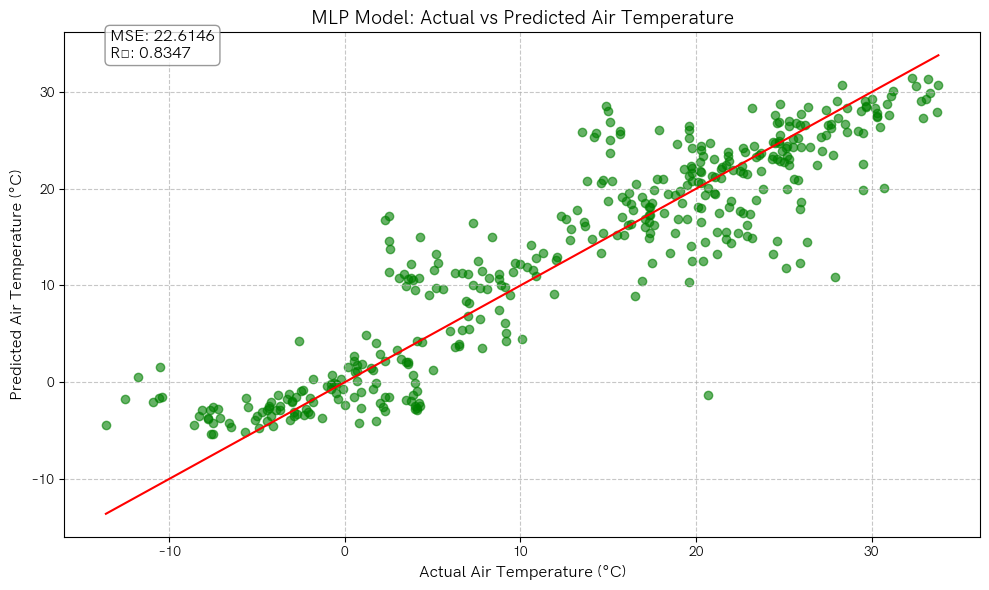

In [45]:
# Actual vs Predicted Plot
plt.rcParams['font.family'] = 'HK Grotesk' 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color ='red')
plt.xlabel('Actual Air Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Air Temperature (°C)', fontsize=12)
plt.title('MLP Model: Actual vs Predicted Air Temperature', fontsize=14)
plt.text(0.05, 0.95, f'MSE: {mse:.4f}\nR²: {r2:.4f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Actual vs Predicted.png'), dpi=300)

In [47]:
def create_air_temp_map(lst_raster_path, ndvi_raster_path, dem_raster_path, output_path, 
                       model, scaler, nodata_value=-9999):
    # Open input rasters
    with rasterio.open(lst_raster_path) as lst_src, \
         rasterio.open(ndvi_raster_path) as ndvi_src, \
         rasterio.open(dem_raster_path) as dem_src:
        
        # Read raster data
        lst_data = lst_src.read(1)
        ndvi_data = ndvi_src.read(1)
        dem_data = dem_src.read(1)
        
        # Create mask for valid data - detect both nodata and NaN values
        lst_mask = (lst_data != nodata_value) & ~np.isnan(lst_data)
        ndvi_mask = (ndvi_data != nodata_value) & ~np.isnan(ndvi_data)
        dem_mask = (dem_data != nodata_value) & ~np.isnan(dem_data)
        
        # Combined mask for all valid data
        mask = lst_mask & ndvi_mask & dem_mask
        
        # Count valid pixels
        valid_pixels = np.sum(mask)
        print(f"Number of valid pixels: {valid_pixels}")
        
        if valid_pixels == 0:
            print("No valid pixels found after masking. Check your input rasters for alignment and valid data.")
            return None
        
        # Prepare input array
        X_pred = np.column_stack([
            lst_data[mask].flatten(),
            ndvi_data[mask].flatten(),
            dem_data[mask].flatten()
        ])
        
        # Check for any remaining NaN values (debug)
        if np.isnan(X_pred).any():
            print("Warning: NaN values in X_pred after masking")
            # Replace any remaining NaNs with mean values
            col_means = np.nanmean(X_pred, axis=0)
            nan_indices = np.where(np.isnan(X_pred))
            X_pred[nan_indices] = np.take(col_means, nan_indices[1])
        
        # Scale the data
        X_pred_scaled = scaler.transform(X_pred)

        # Predict air temperatures
        air_temp_pred = model.predict(X_pred_scaled)
        
        # Create output raster
        air_temp_raster = np.full_like(lst_data, nodata_value, dtype=np.float32)
        air_temp_raster[mask] = air_temp_pred
        
        # Create output raster with same metadata as input
        meta = lst_src.meta.copy()
        meta.update(dtype='float32', nodata=nodata_value)
        
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(air_temp_raster, 1)
    
    print(f"Air temperature map saved to: {output_path}")
    return output_path

In [54]:
# Process all LST files to create air temperature maps
def process_all_lst_files(lst_folder, ndvi_folder, dem_path, output_folder, model, scaler):

    # Get all LST files
    lst_files = glob.glob(os.path.join(lst_folder, "LST_*.tif"))
    print(f"Found {len(lst_files)} LST files to process")
    
    # Process each LST file
    for lst_file in lst_files:
        # Extract year and month from filename
        filename = os.path.basename(lst_file)
        parts = filename.split('_')
        if len(parts) >= 3:
            year = parts[1]
            month = parts[2].split('.')[0]
            
            # Find corresponding NDVI file
            ndvi_file = os.path.join(ndvi_folder, f"NDVI_{year}_{month}.tif")
            
            if os.path.exists(ndvi_file):
                # Define output path
                output_path = os.path.join(output_folder, f"AirTemp_{year}_{month}.tif")
                
                # Create air temperature map
                create_air_temp_map(lst_file, ndvi_file, dem_path, output_path, model, scaler)
                print(f"Processed {filename} -> {os.path.basename(output_path)}")
            else:
                print(f"No matching NDVI file found for {filename}")
    
    print(f"Air temperature maps saved to: {output_folder}")

In [52]:
lst_folder = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/GEE/LST'
ndvi_folder = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/GEE/NDVI'
dem_path = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Data/Satellite Imagery/Elevation DEM.tif'
output_folder = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result/Predicted Air Temp'

process_all_lst_files(lst_folder, ndvi_folder, dem_path, output_folder, mlp, scaler_X)

Found 89 LST files to process
Number of valid pixels: 1576123
Air temperature map saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result/Predicted Air Temp/AirTemp_2024_1.tif
Processed LST_2024_1.tif -> AirTemp_2024_1.tif
Number of valid pixels: 1576003
Air temperature map saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result/Predicted Air Temp/AirTemp_2017_12.tif
Processed LST_2017_12.tif -> AirTemp_2017_12.tif
Number of valid pixels: 1575972
Air temperature map saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result/Predicted Air Temp/AirTemp_2020_5.tif
Processed LST_2020_5.tif -> AirTemp_2020_5.tif
Number of valid pixels: 1576019
Air temperature map saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Python/1st MLP/Result/Predicted Air Temp/AirTemp_2019_1.tif
Processed LST_2019_1.tif -> AirTemp_2019_1.tif
Number of valid pixels: 1575969
Air temperature map